<a href="https://colab.research.google.com/github/danielwhitt/FATE/blob/main/oscar_parcels_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install podaac-data-subscriber
# replace login and password with earth datalogin and password
!touch /root/.netrc
# replace your_uid with your nasa earth data id and replace your_password with your nasa earth data password
#!echo "machine urs.earthdata.nasa.gov login  your_uid password your_password" >> /root/.netrc

!chmod 0600 /root/.netrc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for curlify: filename=curlify-2.2.1-py3-none-any.whl size=2666 sha256=149fa08a561121c8acb18af44439d1f05265ecd509e07545fc7328ad930d870c
  Stored in directory: /root/.cache/pip/wheels/01/e8/2f/e0e986ab1e8956d5ad10aabc059767c822d6114ed295a28dd5
Successfully built curlify
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [2]:
# download the last 30 days of OSCAR near real time surface currents, global files 1/4 degree
# change the start and end dates to the last 30 days
!podaac-data-downloader -c OSCAR_L4_OC_NRT_V2.0 -d ./data --start-date 2024-03-15T00:00:00Z --end-date 2024-04-15T00:00:00Z -e .nc


[2024-04-16 21:23:12,308] {podaac_data_downloader.py:146} INFO - NOTE: Making new data directory at ./data(This is the first run.)
[2024-04-16 21:23:13,414] {podaac_data_downloader.py:317} INFO - Found 30 total files to download
[2024-04-16 21:23:18,252] {podaac_data_downloader.py:358} INFO - 2024-04-16 21:23:18.252837 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240413.nc
[2024-04-16 21:23:20,722] {podaac_data_downloader.py:358} INFO - 2024-04-16 21:23:20.722339 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240412.nc
[2024-04-16 21:23:23,591] {podaac_data_downloader.py:358} INFO - 2024-04-16 21:23:23.591623 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240411.nc
[2024-04-16 21:23:26,060] {podaac_data_downloader.py:358} INFO - 2024-04-16 21:23:26.060633 SUCCESS

In [4]:
# 2002 data for comparison with globcurrent option? This takes 8 minutes, so comment out for now.
#!podaac-data-downloader -c OSCAR_L4_OC_FINAL_V2.0 -d ./data --start-date 2002-01-01T00:00:00Z --end-date 2003-01-01T00:00:00Z -e .nc

In [3]:
# download noaa buoy trajectory data
import urllib
urllib.request.urlretrieve("https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/OSMC_RealTime.nc?platform_type%2Ctime%2Clatitude%2Clongitude%2Cplatform_code&platform_type=%22DRIFTING%20BUOYS%20(GENERIC)%22&time%3E=2024-03-01T00%3A00%3A00Z&latitude%3E=-15&latitude%3C=15&longitude%3E=-180&longitude%3C=-90&orderBy(%22platform_code%2Ctime%22)","/content/buoydatafile.nc")

('/content/buoydatafile.nc', <http.client.HTTPMessage at 0x78eec0127820>)

In [5]:
!pip install parcels
!pip install cftime
!pip install cgen
!pip install trajan
!pip install zarr
!pip install pymbolic

import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)

import parcels as ps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.6/144.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for cgen: filename=cgen-2020.1-py3-none-any.whl size=15821 sha256=12be5729c1167f1e6deed38f16c253dc6430449e7bf625c4707c072713dfd77e
  Stored in directory: /root/.cache/pip/wheels/e6/64/97/7637a7ca9c143c1eaaeeb048c6e772677a68eb4d8695a9cc2a
Successfully built cgen
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.4 MB/s eta 0:00:00

In [18]:
ds=xr.open_mfdataset("/content/data/oscar_currents_nrt_202404*.nc",decode_times=False)
ds['time'] = xr.coding.times.decode_cf_datetime(ds['time'], calendar='gregorian',units='days since 1990-01-01')
#ds.to_netcdf(path="/content/data/oscar_currents_nrt_20240411_greg.nc")



In [19]:
ds

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 13)
Coordinates:
    lat      (latitude) float64 dask.array<chunksize=(719,), meta=np.ndarray>
    lon      (longitude) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2024-04-01 2024-04-02 ... 2024-04-13
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    v        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2024-04-01T00:00:00
    time_coverage_end:          2024-04-01T23:59:59
    date_created:               2024-04-16

In [20]:
variables = {
    "U": "u",
    "V": "v",
}
dimensions = {"time": "time", "lat": "lat", "lon": "lon"}


In [21]:

fieldset=FieldSet.from_xarray_dataset(ds.transpose("time", "latitude", "longitude"),variables,dimensions)


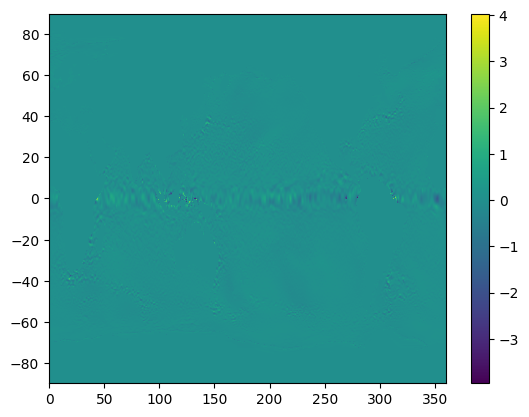

In [22]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[10, :, :]-fieldset.U.data[1, :, :])
#plt.xlabel("Zonal distance [m]")
#plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.show()


In [52]:
pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=50,  # releasing 5 particles
    start=(197, 3),  # releasing on a line: the start longitude and latitude
    finish=(197, 9),  # releasing on a line: the end longitude and latitude
)

In [53]:
output_file = pset.ParticleFile(
    name="OSCARparticles163.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticles163.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticles163.zarr.


100%|██████████| 864000.0/864000.0 [00:06<00:00, 132522.52it/s]


In [54]:
pset1 = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=50,  # releasing 5 particles
    start=(199, 3),  # releasing on a line: the start longitude and latitude
    finish=(199, 9),  # releasing on a line: the end longitude and latitude
)
output_file = pset1.ParticleFile(
    name="OSCARparticles161.zarr", outputdt=timedelta(hours=1)
)
pset1.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticles161.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticles161.zarr.


100%|██████████| 864000.0/864000.0 [00:07<00:00, 118570.33it/s]


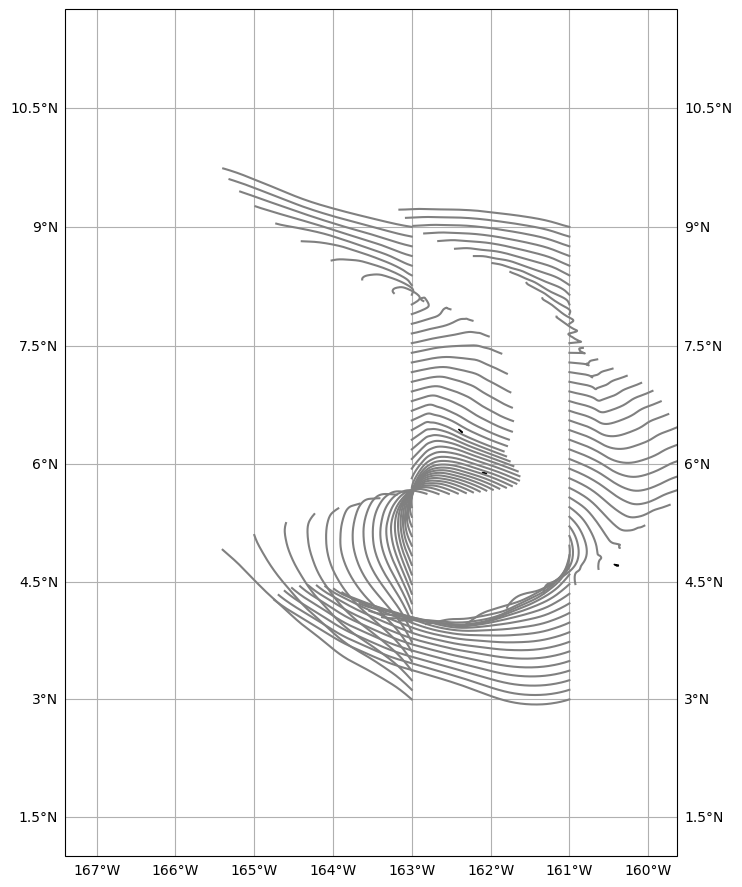

In [55]:
ds = xr.open_zarr("OSCARparticles163.zarr")
ds.traj.plot(margin=2)
ds1 = xr.open_zarr("OSCARparticles161.zarr")
ds1.traj.plot(margin=1)
plt.show()


